Följande bibliotek behövs:

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
from bs4 import BeautifulSoup
import requests
import ast
import seaborn as sns
sns.set(style="whitegrid", font_scale = 1.3)

I följande dict defineras vad som ska sökas efter:

In [3]:
url_params = {
    'location_ids' : ['473277'], # Kolla söksträngen på hemnet
    'item_types' : ['villa'], # 'bostadsratt', 'villa', 'radhus' osv
    'rooms_min' : '', # Lägst antal rum
    'rooms_max' : '', # Högst antal rum
    'living_area_min' : '', # Lägst antal kvm
    'living_area_max' : '', # Högst antal kvm
    'fee_min' : '', # Lägsta månadsavgiften
    'fee_max' : '', # Högsta månadsavgiften
    'sold_age' : '', # Tom för 12 månaders historik. Sätt denna till 'all' för att ta med historik from 2013. 
}

In [4]:
# Skapa url från dict ovan
url_string = 'https://www.hemnet.se/salda/bostader?'

locations_ids_list = url_params.get('location_ids')
i = 0
for location_id in locations_ids_list:
    i = i + 1
    if i > 1:
        url_string = url_string + '&'
    url_string = url_string + 'location_ids%5B%5D=' + location_id

item_types_list = url_params.get('item_types')
for item_type in item_types_list:
    url_string = url_string + '&item_types%5B%5D=' + item_type

if url_params.get('rooms_min'):
    url_string = url_string + '&rooms_min=' + url_params.get('rooms_min')

if url_params.get('rooms_max'):
    url_string = url_string + '&rooms_max=' + url_params.get('rooms_max')

if url_params.get('living_area_min'):
    url_string = url_string + '&living_area_min=' + url_params.get('living_area_min')

if url_params.get('living_area_max'):
    url_string = url_string + '&living_area_max=' + url_params.get('living_area_max')
    
if url_params.get('fee_min'):
    url_string = url_string + '&fee_min=' + url_params.get('fee_min')
    
if url_params.get('fee_max'):
    url_string = url_string + '&fee_max=' + url_params.get('fee_max')

if url_params.get('sold_age'):
    url_string = url_string + '&sold_age=' + url_params.get('sold_age')

In [5]:
page = 0
all_lgh_link_list = []
while True:
    page = page + 1
    sida = requests.get(url_string+'&page='+str(page), headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(sida.content)
    
    if soup.find_all('div', class_='sold-zero-hits'):
        break
    else:
        omraden_soup = soup.find('div', class_='location-search-post textinput')
        input_string = omraden_soup.find('input').get('value')
        input_list = ast.literal_eval(input_string)
        omrade_string =''
        for omrade_info in input_list:
            omrade_string = omrade_string + omrade_info['name'] + ', ' + omrade_info['parent_name'] +'\n'
        
        lgh_link_list = soup.find_all('a',class_='item-link-container')
        all_lgh_link_list.extend(lgh_link_list)

In [6]:
data_dict_list = []
for lgh_link in all_lgh_link_list:
    lgh_sida = requests.get(lgh_link['href'], headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(lgh_sida.content, from_encoding='utf-8')
    
    body = soup.find('body')
    script = body.find_all('script')[1]
    text = script.getText()
    
    start_index = text.find('{\"sold_property')
    end_index = text.find('}}]')
    
    data = text[start_index+17:end_index]
    #avgift = body.find_all('dd', class_='sold-property__attribute-value')[5].getText()
    if soup.find('dt', text="Avgift/månad"):
        avgift = soup.find('dt', text="Avgift/månad").next_sibling.next_sibling.getText()
        avgift = int(avgift[0:len(avgift)-7].encode('ascii','ignore'))
    else:
        avgift = -1
        
    if soup.find('dt', text="Byggår"):
        byggar = soup.find('dt', text="Byggår").next_sibling.next_sibling.getText()
    else:
        byggar = -1
    try:
        byggar = int(byggar)
    except ValueError:
        byggar = -1
    if byggar == 0:
        byggar = -1
    
    typ_text_soup = body.find('p', class_='sold-property__metadata')
    typ = typ_text_soup.find('title').getText()  

    data = data + ",\"avgift\": " + str(avgift) + ",\"byggar\" : " + str(byggar) + " ,\"typ\" : \"" + typ + "\"} "
    data_dict = ast.literal_eval(data)
    data_dict_list.append(data_dict)

In [7]:
lgh_df = pd.DataFrame(data_dict_list)
lgh_df = lgh_df.astype({'living_area':'float64','rooms':'float64','sold_at_date':'datetime64'})
lgh_df['utgang_kvm_pris'] = round(lgh_df['price']/lgh_df['living_area'],0)
lgh_df['slut_kvm_pris'] = round(lgh_df['selling_price']/lgh_df['living_area'],0)
lgh_df = lgh_df.replace(-1,np.NaN)
lgh_df = lgh_df.astype({'byggar':'Int64'})

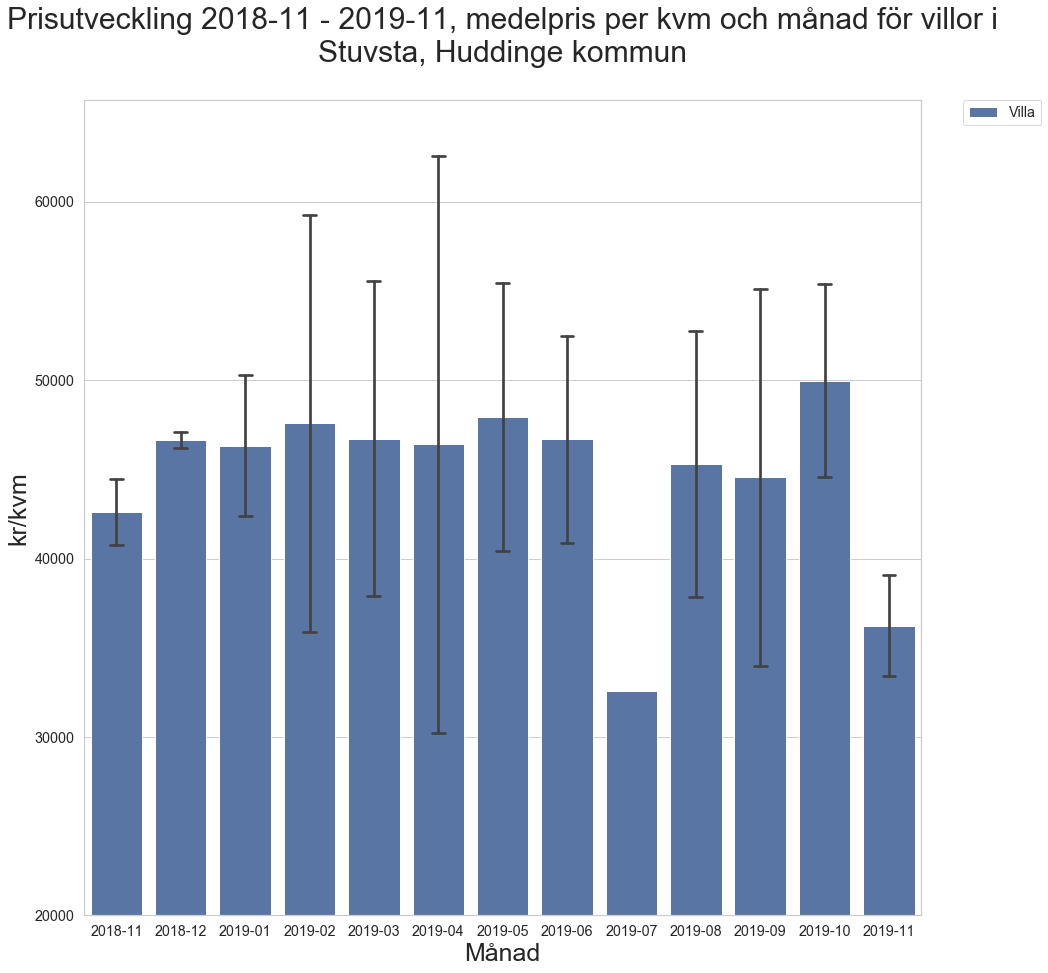

In [18]:
lgh_df['sald_manad'] = lgh_df['sold_at_date'].apply(lambda x: x.strftime('%Y-%m'))

order = list(reversed(lgh_df['sald_manad'].unique()))

g = sns.barplot(x="sald_manad", y="slut_kvm_pris", hue="typ", data=lgh_df, capsize=.2, order=order, ci='sd')
g.set_ylabel('kr/kvm',fontsize=25)
g.set_xlabel('Månad',fontsize=25)
g.set_ylim(20000,)

g.set_title('Prisutveckling ' + order[0] + ' - ' + order[len(order)-1] +', medelpris per kvm och månad för villor i' + '\n' + omrade_string,fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

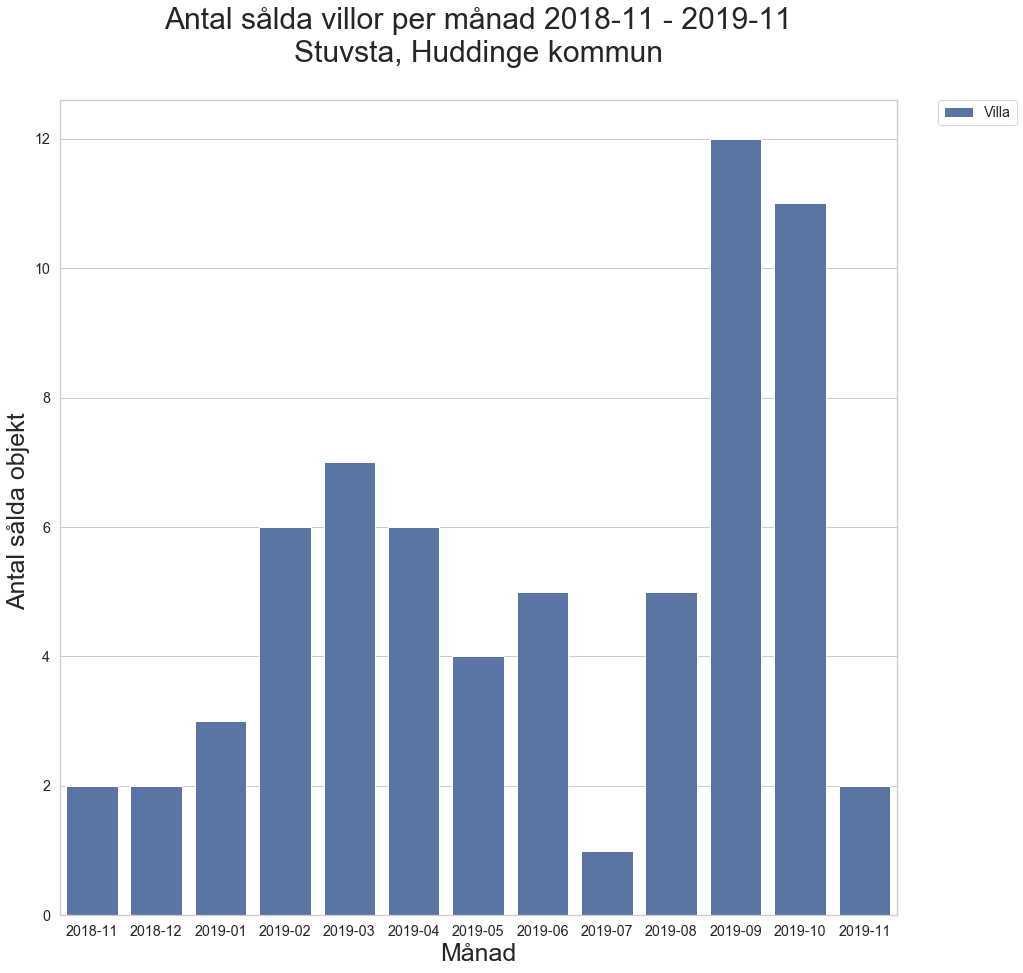

In [19]:
g = sns.barplot(x="sald_manad", y="slut_kvm_pris", hue="typ", data=lgh_df, order=order, estimator=len)
g.set_ylabel('Antal sålda objekt ',fontsize=25)
g.set_xlabel('Månad',fontsize=25)
g.set_title('Antal sålda villor per månad '+ order[0] + ' - ' + order[len(order)-1] + '\n' + omrade_string,fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

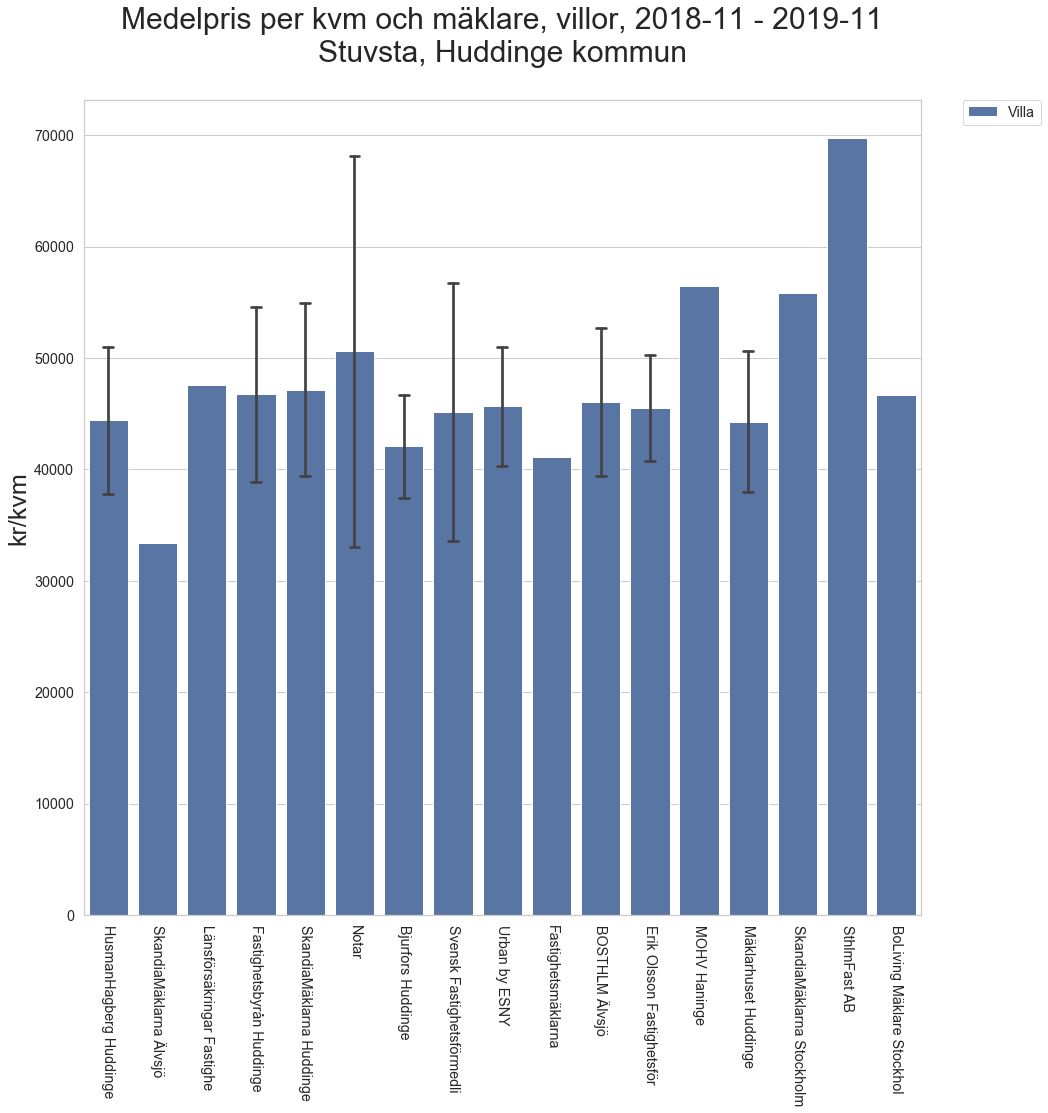

In [20]:
lgh_df['broker_agency'] = lgh_df['broker_agency'].apply(lambda x: x[0:25])

g = sns.barplot(x="broker_agency", y="slut_kvm_pris", hue="typ", data=lgh_df, capsize=.2, ci='sd')
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=270)
g.set_ylabel('kr/kvm',fontsize=25)
g.set_xlabel('',fontsize=25)
g.set_title('Medelpris per kvm och mäklare, villor, ' + order[0] + ' - ' + order[len(order)-1]+ '\n' + omrade_string,fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

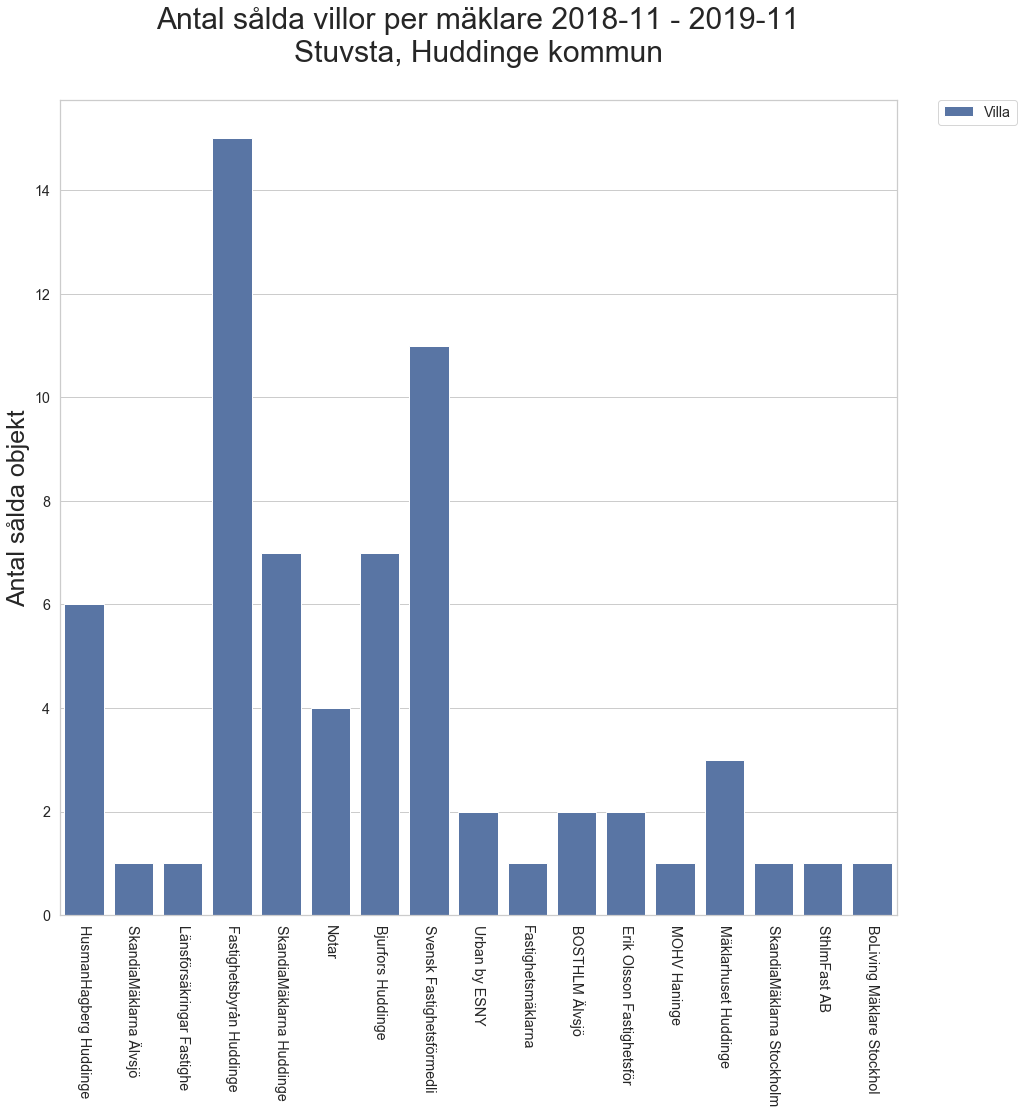

In [21]:
g = sns.barplot(x="broker_agency", y="slut_kvm_pris", hue="typ", data=lgh_df, estimator=len)
g.set_ylabel('Antal sålda objekt ',fontsize=25)
g.set_xlabel('Månad',fontsize=25)
g.set_title('Antal sålda villor per mäklare '+ order[0] + ' - ' + order[len(order)-1] + '\n' + omrade_string,fontsize=30)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=270)
g.set_ylabel('Antal sålda objekt',fontsize=25)
g.set_xlabel('',fontsize=25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [12]:
print(lgh_df['broker_agency'].unique())

['HusmanHagberg Huddinge' 'SkandiaMäklarna Älvsjö'
 'Länsförsäkringar Fastighe' 'Fastighetsbyrån Huddinge'
 'SkandiaMäklarna Huddinge' 'Notar' 'Bjurfors Huddinge'
 'Svensk Fastighetsförmedli' 'Urban by ESNY' 'Fastighetsmäklarna'
 'BOSTHLM Älvsjö' 'Erik Olsson Fastighetsför' 'MOHV Haninge'
 'Mäklarhuset Huddinge' 'SkandiaMäklarna Stockholm' 'SthlmFast AB'
 'BoLiving Mäklare Stockhol']


48968.93570990255


Text(0.5,1,'Normalkurva, försäljningspriser för Erik Olsson Fastighetsför\n2018-11 - 2019-11')

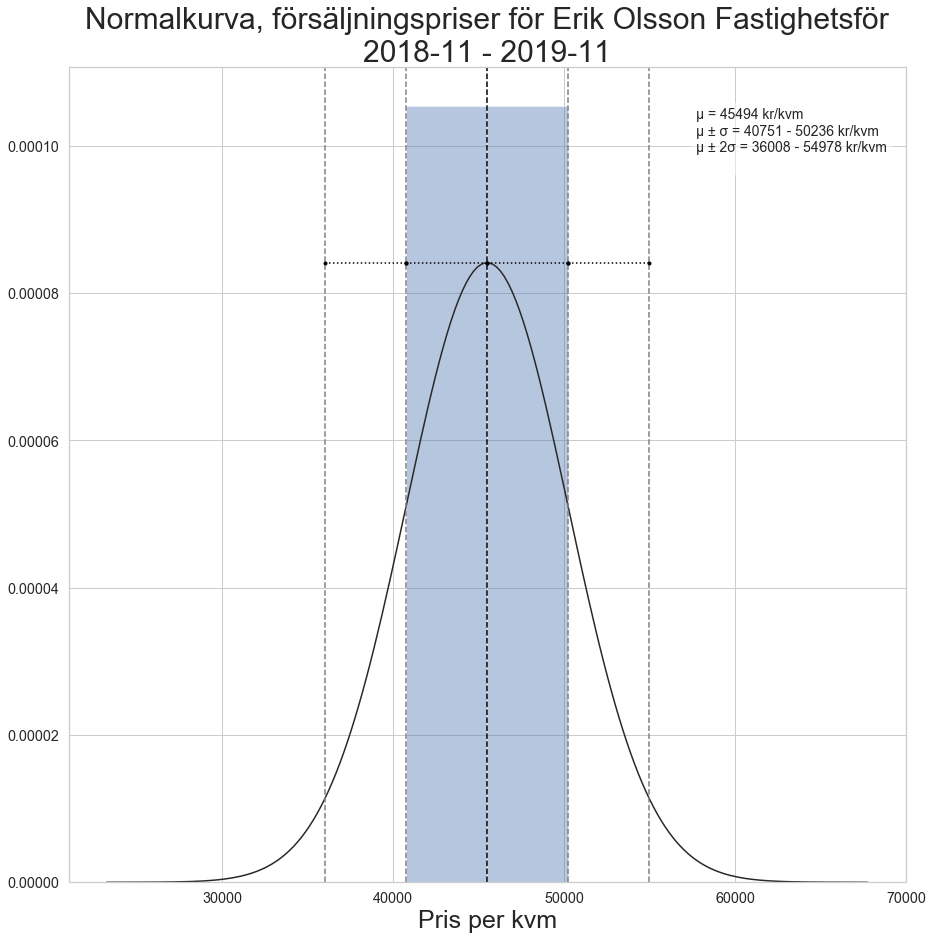

In [13]:
from scipy.stats import norm
maklar_namn = 'Erik Olsson Fastighetsför'


lgh_df_filtered_maklare = lgh_df[lgh_df['broker_agency']==maklar_namn]
antal = len(lgh_df_filtered_maklare)

mean = np.mean(lgh_df_filtered_maklare['slut_kvm_pris'])
std = np.std(lgh_df_filtered_maklare['slut_kvm_pris'])

g = sns.distplot(lgh_df_filtered_maklare['slut_kvm_pris'],kde=False,fit=norm,hist=True,norm_hist=True)
ax = g.axes
ax.axvline(mean,ls='--',c='black')
pdf = norm.pdf(mean, mean, std)
xlim = ax.get_xlim()
x_range = xlim[1] - xlim[0]
print (x_range)
norm_std = std/x_range
norm_mean = (mean-xlim[0])/x_range
ax.axvline(mean+std,ls='--',c='gray')
ax.axvline(mean+2*std,ls='--',c='gray')
ax.axvline(mean-std,ls='--',c='gray')
ax.axvline(mean-2*std,ls='--',c='gray')
ax.axhline(pdf, xmin=norm_mean, xmax=norm_mean+norm_std, marker='.', c='black', ls=':')
ax.axhline(pdf, xmin=norm_mean+norm_std, xmax=norm_mean+2*norm_std, marker='.', c='black', ls=':')
ax.axhline(pdf, xmin=norm_mean, xmax=norm_mean-norm_std, marker='.', c='black', ls=':')
ax.axhline(pdf, xmin=norm_mean-norm_std, xmax=norm_mean-2*norm_std, marker='.', c='black', ls=':')
textstr = "μ = " + str(int(round(mean,0))) + " kr/kvm\n" + "μ ± σ = " + str(int(round(mean - std,0))) + " - " +str(int(round(mean + std,0))) + " kr/kvm\n" +  "μ ± 2σ = " + str(int(round(mean - 2*std,0))) + " - " +str(int(round(mean + 2*std,0))) + " kr/kvm\n" 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top',bbox=props)
g.set_xlabel('Pris per kvm',fontsize=25)
g.set_title('Normalkurva, försäljningspriser för ' + maklar_namn + '\n' + order[0] + ' - ' + order[len(order)-1],fontsize=30)

Text(0.5,1,'Procentuell medelskillnad slutpris/utgångspris per mäklare 2018-11 - 2019-11\nStuvsta, Huddinge kommun\n')

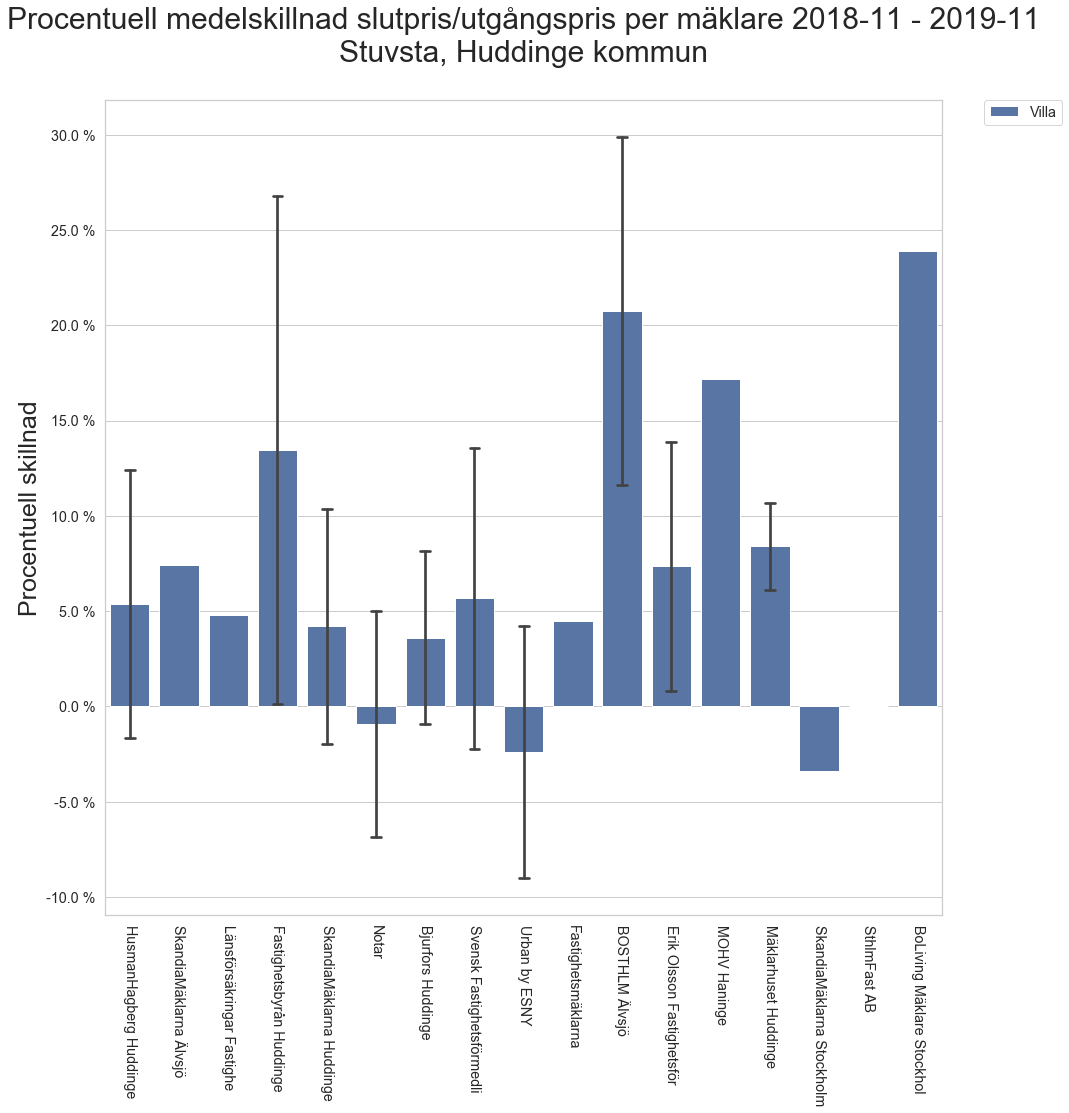

In [14]:
lgh_df['diff_kvm_pris'] = round((lgh_df['slut_kvm_pris']/lgh_df['utgang_kvm_pris']-1)*100,1)
g = sns.barplot(x="broker_agency", y="diff_kvm_pris", hue="typ", data=lgh_df, capsize=.2, ci='sd')
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=270)
vals = g.get_yticks()
g.set_yticklabels([format(x) +' %' for x in vals])
g.set_xlabel('',fontsize=25)
g.set_ylabel('Procentuell skillnad',fontsize=25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_title('Procentuell medelskillnad slutpris/utgångspris per mäklare '+ order[0] + ' - ' + order[len(order)-1] + '\n' + omrade_string,fontsize=30)

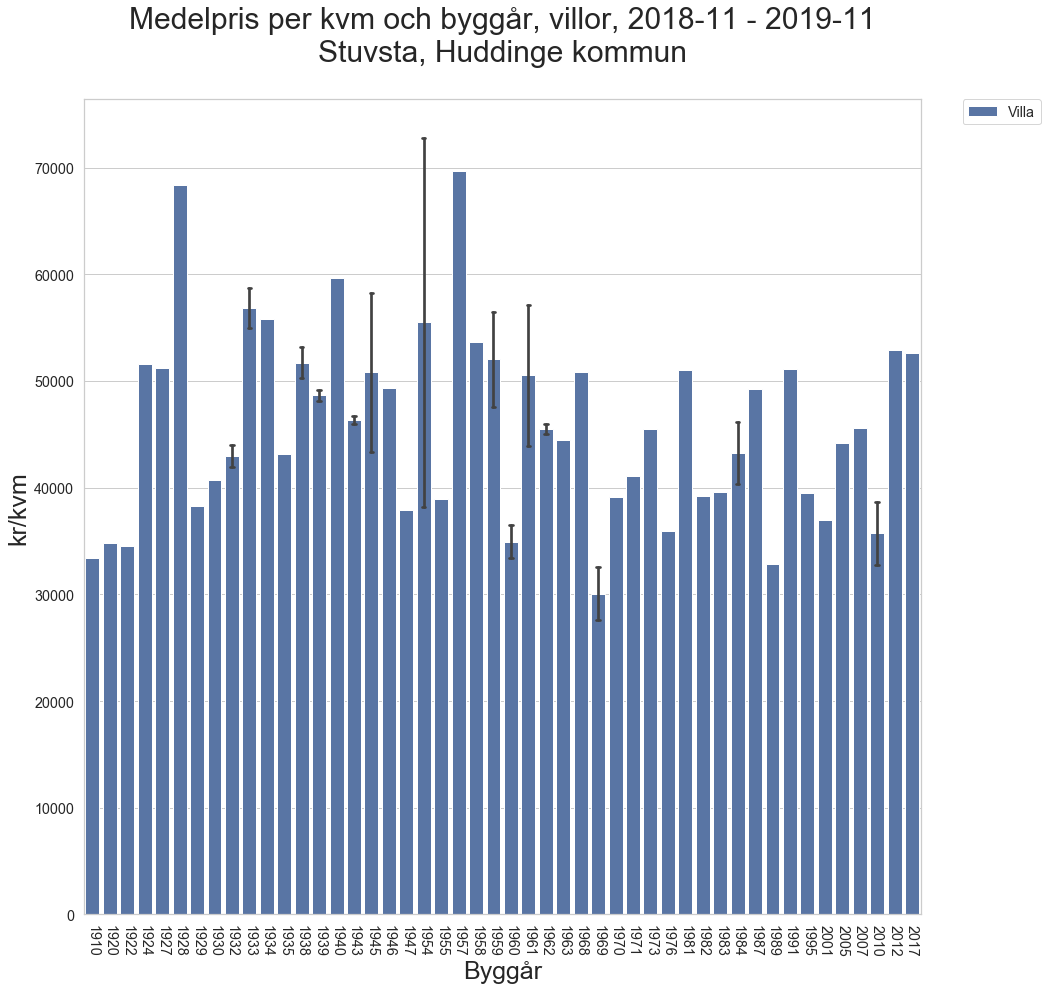

In [22]:
g = sns.barplot(x="byggar", y="slut_kvm_pris", hue="typ", data=lgh_df, capsize=.2, ci='sd')
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=270)
g.set_ylabel('kr/kvm',fontsize=25)
g.set_xlabel('Byggår',fontsize=25)
g.set_title('Medelpris per kvm och byggår, villor, ' + order[0] + ' - ' + order[len(order)-1]+ '\n' + omrade_string,fontsize=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [16]:
print(lgh_df['byggar'].unique())

<IntegerArray>
[1970, 1960, 1959, 1927, 1933, 1958, 1961, 1924, 1962, 1939, 1940, 1969, 1928,
 1929, 1981, 2005, 1943, 1910, 1932, 1971, 2007, 1982, 1945, 1995, 1987, 1984,
 2001, 2017, 1946, 1991, 1938, 1976, 1989, 2012, 1954, 1922, 1983, 1955, 1934,
 2010, 1968, 1947, 1920, 1957, 1935, 1973, 1963, 1930]
Length: 48, dtype: Int64


ValueError: `dataset` input should have multiple elements.

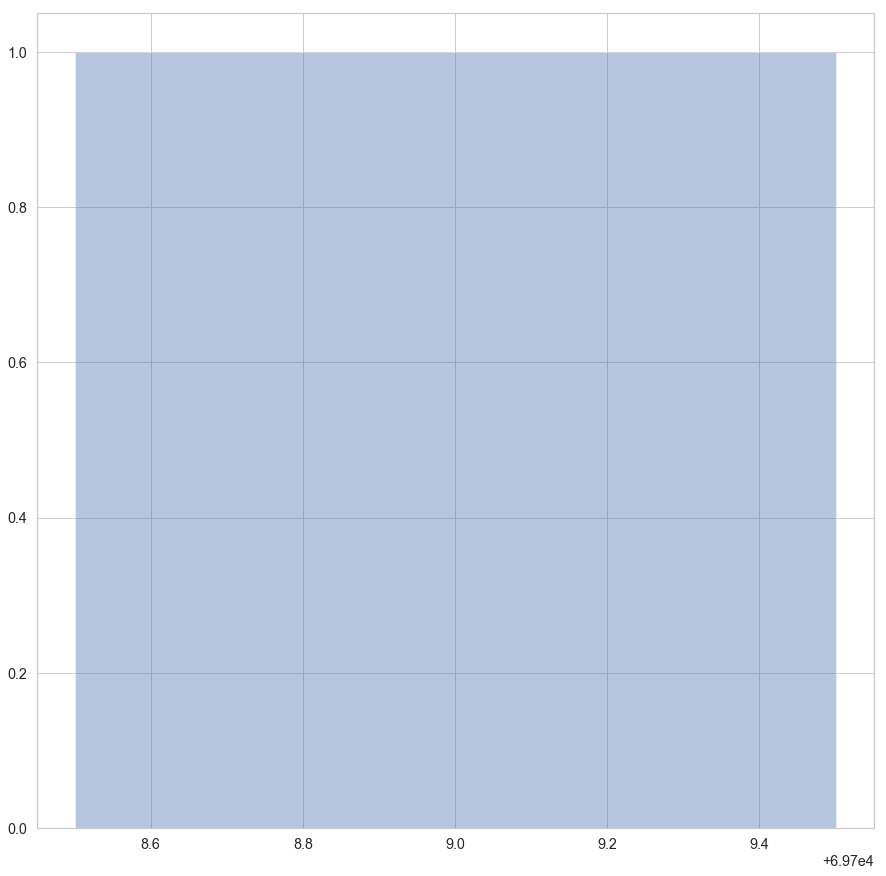

In [17]:
from scipy.stats import norm
from scipy.stats import lognorm
bygg = 1957


lgh_df_filtered_maklare = lgh_df[lgh_df['byggar']==bygg]
antal = len(lgh_df_filtered_maklare)

mean = np.mean(lgh_df_filtered_maklare['slut_kvm_pris'])
std = np.std(lgh_df_filtered_maklare['slut_kvm_pris'])


g = sns.distplot(lgh_df_filtered_maklare['slut_kvm_pris'],kde=False,fit=norm,hist=True,norm_hist=True)
ax = g.axes
ax.axvline(mean,ls='--',c='black')
pdf = norm.pdf(mean, mean, std)
xlim = ax.get_xlim()
x_range = xlim[1] - xlim[0]
print (x_range)
norm_std = std/x_range
norm_mean = (mean-xlim[0])/x_range
ax.axvline(mean+std,ls='--',c='gray')
ax.axvline(mean+2*std,ls='--',c='gray')
ax.axvline(mean-std,ls='--',c='gray')
ax.axvline(mean-2*std,ls='--',c='gray')
ax.axhline(pdf, xmin=norm_mean, xmax=norm_mean+norm_std, marker='.', c='black', ls=':')
ax.axhline(pdf, xmin=norm_mean+norm_std, xmax=norm_mean+2*norm_std, marker='.', c='black', ls=':')
ax.axhline(pdf, xmin=norm_mean, xmax=norm_mean-norm_std, marker='.', c='black', ls=':')
ax.axhline(pdf, xmin=norm_mean-norm_std, xmax=norm_mean-2*norm_std, marker='.', c='black', ls=':')
textstr = "μ = " + str(int(round(mean,0))) + " kr/kvm\n" + "μ ± σ = " + str(int(round(mean - std,0))) + " - " +str(int(round(mean + std,0))) + " kr/kvm\n" +  "μ ± 2σ = " + str(int(round(mean - 2*std,0))) + " - " +str(int(round(mean + 2*std,0))) + " kr/kvm\n" 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top',bbox=props)
g.set_xlabel('Pris per kvm',fontsize=25)
g.set_title('Normalkurva, försäljningspriser för byggår ' + str(bygg) + '\n' + order[0] + ' - ' + order[len(order)-1],fontsize=30)

In [ ]:
mu, std = norm.fit(lgh_df_filtered_maklare['slut_kvm_pris'])
plt.hist(lgh_df_filtered_maklare['slut_kvm_pris'], bins=10, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(0, xmax+20000, 100)
p = norm.pdf(x, mu, std)
fig = plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.axvline(mean,ls='--',c='black')